In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn


# make sure the current path is Code/
os.chdir('..')
from PLS_Silvia.helpers_PLS import *

# **Predicting using FMRI data the behavior**

The idea is to use some data in order to predict the behavior. <br>

The first step that will be implemented will be to take each of the big5 and perform CPM on 1 single movie on bold and the other higher level info. 

### **CPM, 1 Big Five and 1 single film, BOLD and triangles**

**STEPS:**
1. Load and Preprocess the Data: 
- Load your connectome data and the behavioral feature.
- Normalize or standardize your data as necessary.
2. Feature Selection:
- Calculate the correlation between each connectivity feature and the behavioral variable.
- Select features (edges) with a correlation above a certain threshold.
3. Model Building:
- Divide your data into a training set and a test set.
- Use the selected features to build a predictive model (e.g., linear regression) on the training set.
4. Validation:
- Evaluate the model on the test set.
- Calculate prediction accuracy, using metrics like correlation or mean squared error between predicted and actual behavioral scores.
5. Cross-Validation:
- Implement cross-validation to ensure that your model is robust and generalizes well to new data.

In [5]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

In [6]:
# Load the Y behavioural data
PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/'
columns = ['BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope']

Y = pd.read_csv(PATH_DATA + 'participants.tsv', sep='\t', header=0)[columns]
extrovercy = Y['BIG5_ext']
agreeableness = Y['BIG5_agr']
conscientiousness = Y['BIG5_con']
neuroticism = Y['BIG5_neu']
openness = Y['BIG5_ope']

# Normalize the data
extrovercy = (extrovercy - extrovercy.mean()) / extrovercy.std()
agreeableness = (agreeableness - agreeableness.mean()) / agreeableness.std()
conscientiousness = (conscientiousness - conscientiousness.mean()) / conscientiousness.std()
neuroticism = (neuroticism - neuroticism.mean()) / neuroticism.std()
openness = (openness - openness.mean()) / openness.std()

In [16]:
PATH_YEO = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/yeo_RS7_Schaefer100S.mat'

def compute_X(PATH, movie, method, regions = None):
    yeo_dict = loading_yeo(PATH_YEO)
    yeo_indices = yeo_dict[regions] if regions != 'ALL' else None
    N = 114 if regions == 'ALL' else len(yeo_indices)

    if method == 'bold':
        list_subjects = []
        for i in glob.glob(PATH+'*'):
            if (i.split('/')[-1].split('-')[0] == 'TC_114_sub') & (i.split('/')[-1].split('-')[1].endswith(f'{movie}.txt')):
                list_subjects.append(i)
        mtx_upper_triangular = []
        for i, PATH_SUBJ in enumerate(list_subjects):
            data_feature = pd.read_csv(PATH_SUBJ, sep=' ', header=None)
            if regions == 'ALL':
                connectivity_matrix = np.corrcoef(data_feature, rowvar=False)
            else:
                connectivity_matrix = np.corrcoef(data_feature, rowvar=False)[:,yeo_indices]
            upper_triangular = connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)]
            mtx_upper_triangular.append(upper_triangular)
        mtx_upper_triangular = np.array(mtx_upper_triangular)
        X = pd.DataFrame(mtx_upper_triangular)
        print('The shape of X for BOLD is: ', X.shape)

    return X

X_atr = {}
for method in ['bold']: #'scaffold', 'edges', 'triangles']:
    PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Data_TC/'
    movie = 'Rest'
    X = compute_X(PATH_DATA, movie, method, regions = 'ALL')

print('The shape of X for BOLD is: ', X.shape)

The shape of X for BOLD is:  (30, 6441)
The shape of X for BOLD is:  (30, 6441)


Computing CPM for AfterTheRain and ALL and bold and 0.1
The shape of X for BOLD is:  (30, 6441)


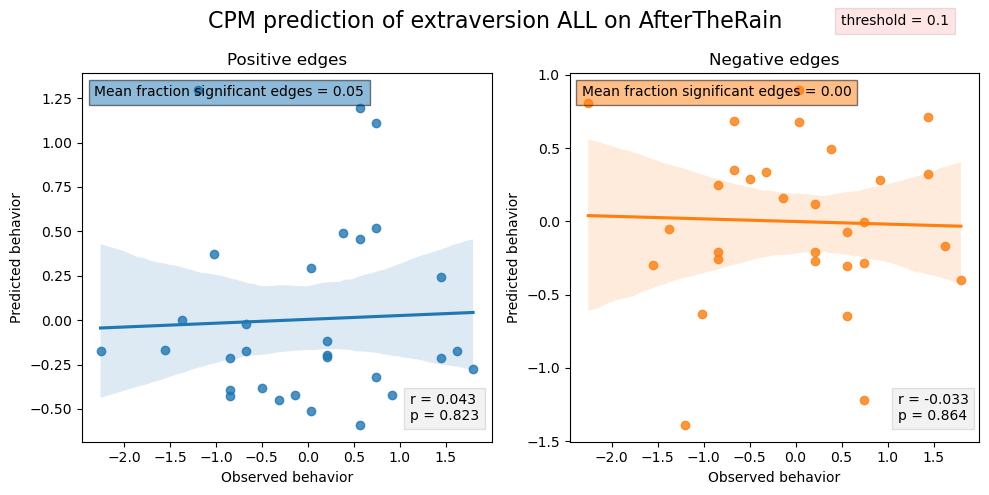

Number of significant points for AfterTheRain and ALL and bold and 0.1 is: 0.0012782694198623405 and 0.049065880039331364
Positive edges: r = 0.043, p = 0.823
Negative edges: r = -0.033, p = 0.864
Computing CPM for AfterTheRain and VIS and bold and 0.1
The shape of X for BOLD is:  (30, 136)


<Figure size 640x480 with 0 Axes>

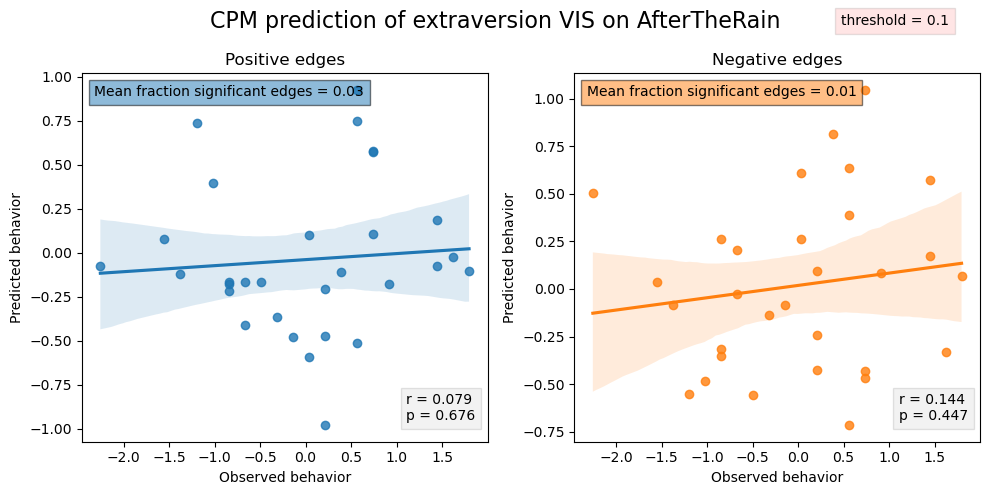

Number of significant points for AfterTheRain and VIS and bold and 0.1 is: 0.008333333333333333 and 0.027941176470588233
Positive edges: r = 0.079, p = 0.676
Negative edges: r = 0.144, p = 0.447
Computing CPM for AfterTheRain and SM and bold and 0.1
The shape of X for BOLD is:  (30, 91)


<Figure size 640x480 with 0 Axes>

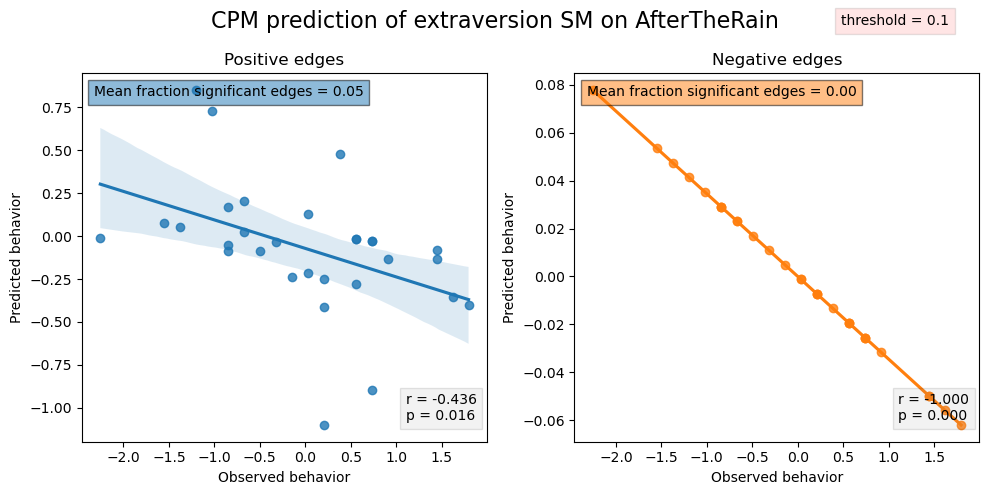

Number of significant points for AfterTheRain and SM and bold and 0.1 is: 0.0 and 0.04945054945054945
Positive edges: r = -0.436, p = 0.016
Negative edges: r = -1.000, p = 0.000
Computing CPM for AfterTheRain and VA and bold and 0.1
The shape of X for BOLD is:  (30, 66)


<Figure size 640x480 with 0 Axes>

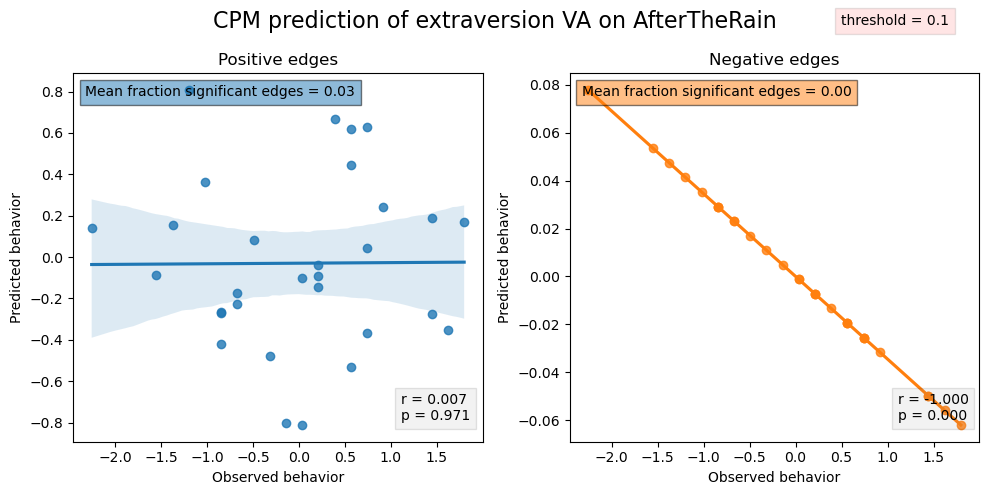

Number of significant points for AfterTheRain and VA and bold and 0.1 is: 0.0 and 0.03282828282828283
Positive edges: r = 0.007, p = 0.971
Negative edges: r = -1.000, p = 0.000
Computing CPM for AfterTheRain and DA and bold and 0.1
The shape of X for BOLD is:  (30, 105)


<Figure size 640x480 with 0 Axes>

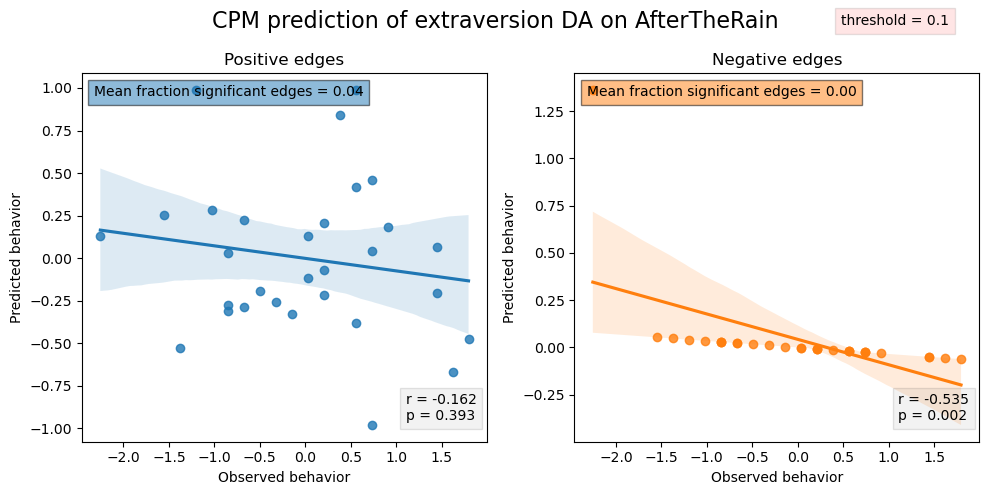

Number of significant points for AfterTheRain and DA and bold and 0.1 is: 0.000634920634920635 and 0.04317460317460317
Positive edges: r = -0.162, p = 0.393
Negative edges: r = -0.535, p = 0.002
Computing CPM for AfterTheRain and DMN and bold and 0.1
The shape of X for BOLD is:  (30, 276)


<Figure size 640x480 with 0 Axes>

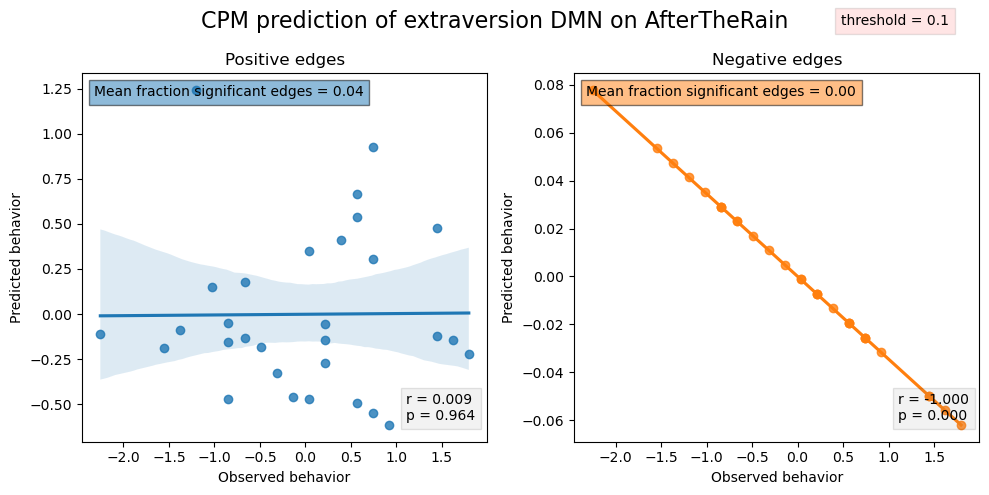

Number of significant points for AfterTheRain and DMN and bold and 0.1 is: 0.0 and 0.04263285024154591
Positive edges: r = 0.009, p = 0.964
Negative edges: r = -1.000, p = 0.000
Computing CPM for AfterTheRain and FP and bold and 0.1
The shape of X for BOLD is:  (30, 78)


<Figure size 640x480 with 0 Axes>

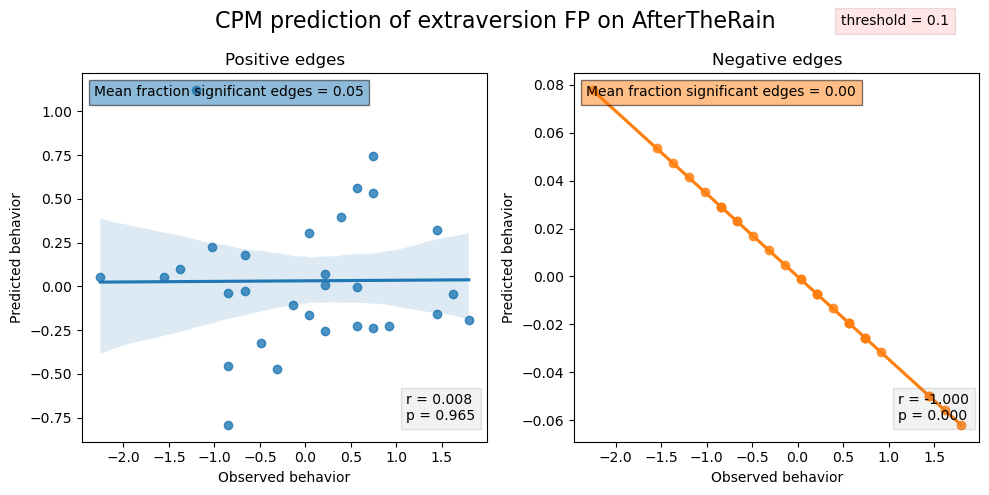

Number of significant points for AfterTheRain and FP and bold and 0.1 is: 0.0 and 0.05470085470085471
Positive edges: r = 0.008, p = 0.965
Negative edges: r = -1.000, p = 0.000
Computing CPM for BetweenViewings and ALL and bold and 0.1
The shape of X for BOLD is:  (30, 6441)


<Figure size 640x480 with 0 Axes>

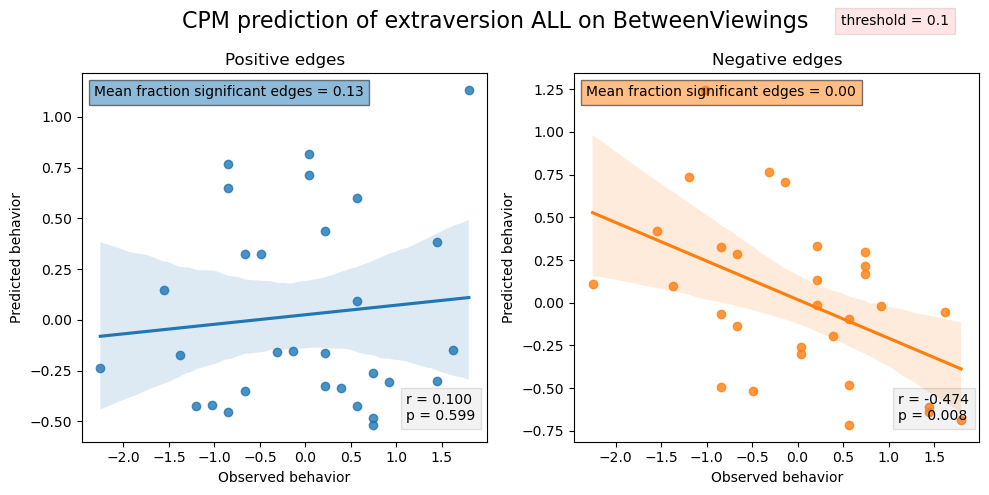

Number of significant points for BetweenViewings and ALL and bold and 0.1 is: 0.0005589194224499301 and 0.12898618226983385
Positive edges: r = 0.100, p = 0.599
Negative edges: r = -0.474, p = 0.008
Computing CPM for BetweenViewings and VIS and bold and 0.1
The shape of X for BOLD is:  (30, 136)


<Figure size 640x480 with 0 Axes>

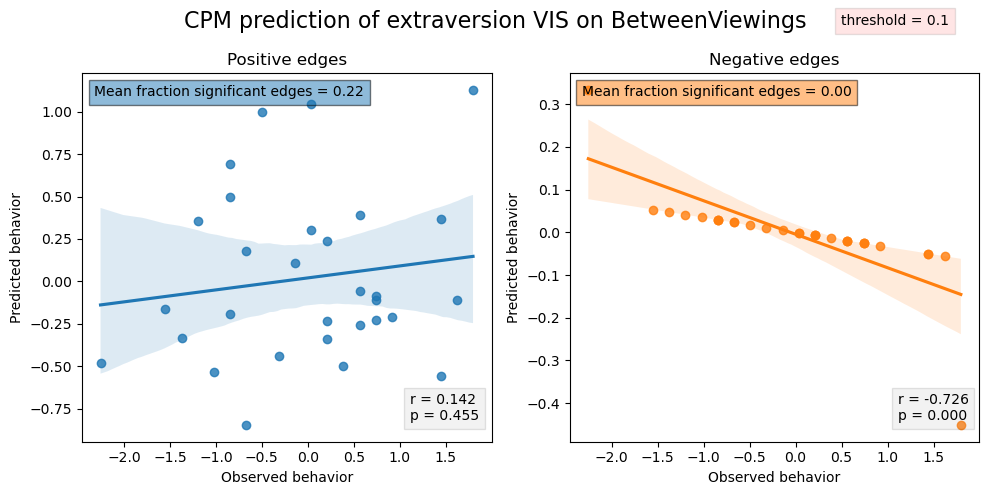

Number of significant points for BetweenViewings and VIS and bold and 0.1 is: 0.0004901960784313725 and 0.21887254901960784
Positive edges: r = 0.142, p = 0.455
Negative edges: r = -0.726, p = 0.000
Computing CPM for BetweenViewings and SM and bold and 0.1
The shape of X for BOLD is:  (30, 91)


<Figure size 640x480 with 0 Axes>

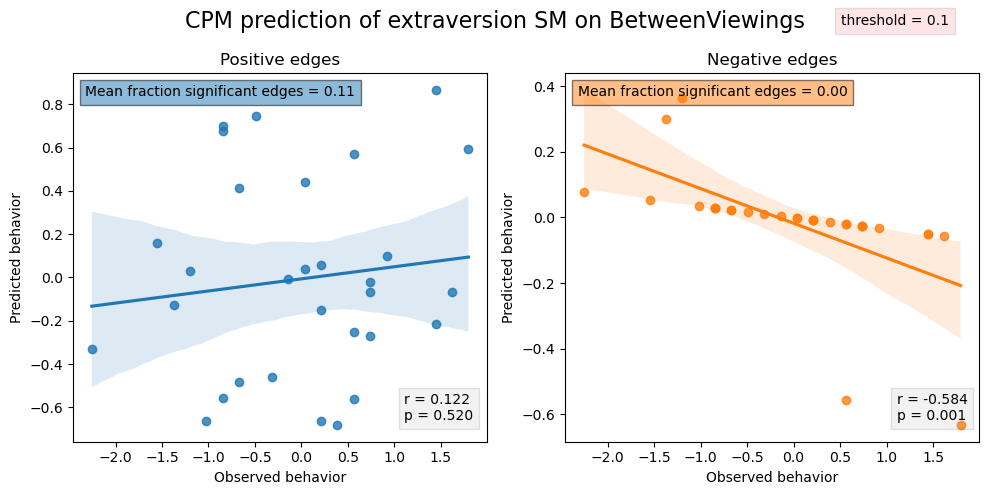

Number of significant points for BetweenViewings and SM and bold and 0.1 is: 0.0018315018315018315 and 0.1098901098901099
Positive edges: r = 0.122, p = 0.520
Negative edges: r = -0.584, p = 0.001
Computing CPM for BetweenViewings and VA and bold and 0.1
The shape of X for BOLD is:  (30, 66)


<Figure size 640x480 with 0 Axes>

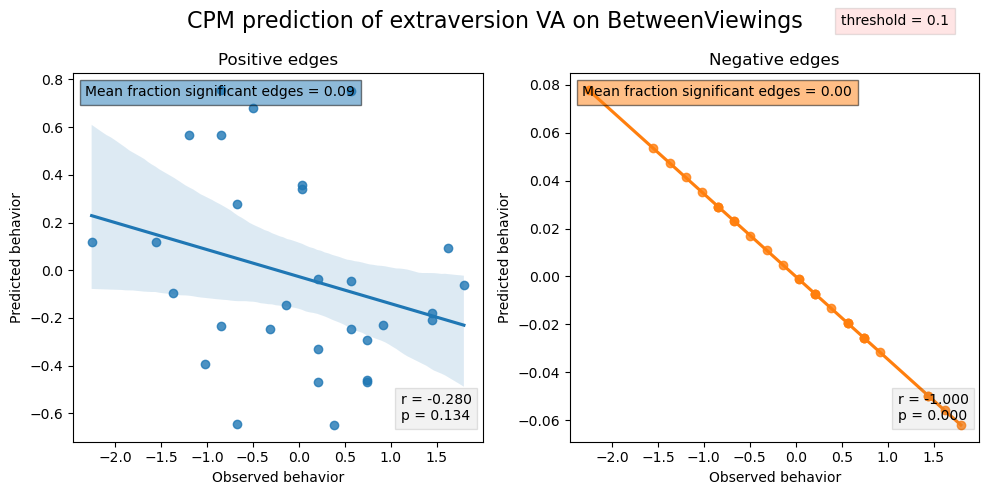

Number of significant points for BetweenViewings and VA and bold and 0.1 is: 0.0 and 0.0898989898989899
Positive edges: r = -0.280, p = 0.134
Negative edges: r = -1.000, p = 0.000
Computing CPM for BetweenViewings and DA and bold and 0.1
The shape of X for BOLD is:  (30, 105)


<Figure size 640x480 with 0 Axes>

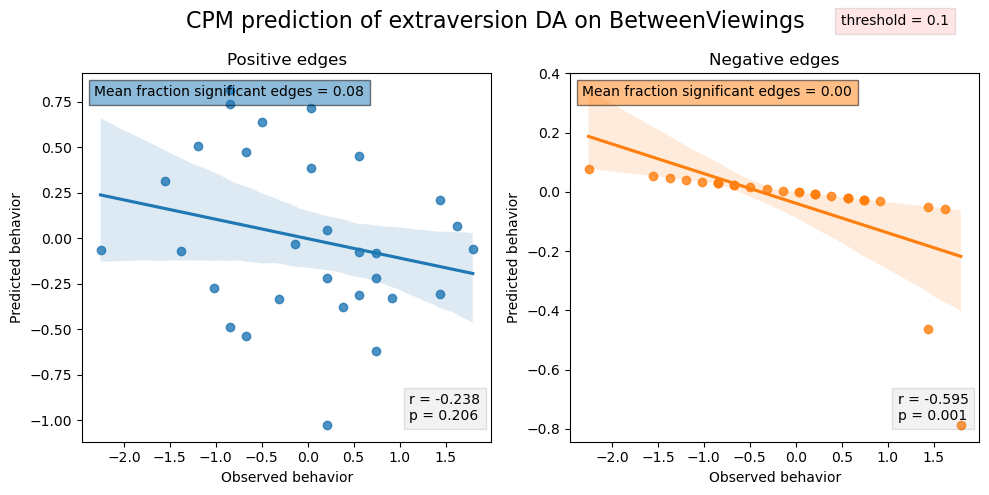

Number of significant points for BetweenViewings and DA and bold and 0.1 is: 0.0009523809523809525 and 0.08222222222222222
Positive edges: r = -0.238, p = 0.206
Negative edges: r = -0.595, p = 0.001
Computing CPM for BetweenViewings and DMN and bold and 0.1
The shape of X for BOLD is:  (30, 276)


<Figure size 640x480 with 0 Axes>

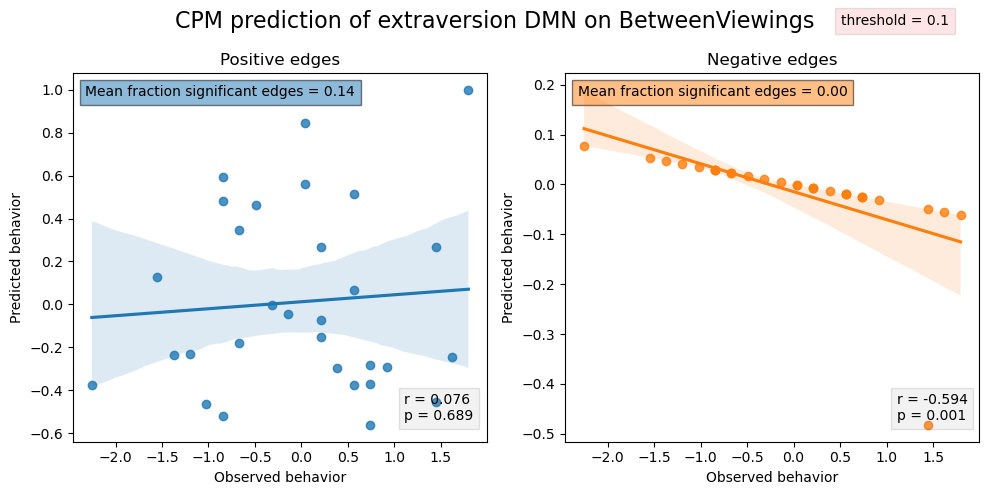

Number of significant points for BetweenViewings and DMN and bold and 0.1 is: 0.00012077294685990338 and 0.13502415458937198
Positive edges: r = 0.076, p = 0.689
Negative edges: r = -0.594, p = 0.001
Computing CPM for BetweenViewings and FP and bold and 0.1
The shape of X for BOLD is:  (30, 78)


<Figure size 640x480 with 0 Axes>

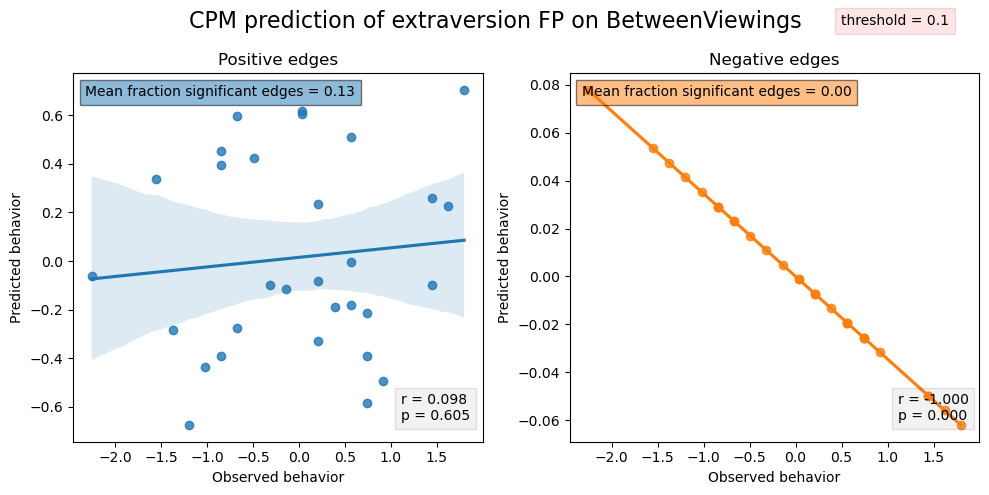

Number of significant points for BetweenViewings and FP and bold and 0.1 is: 0.0 and 0.12905982905982907
Positive edges: r = 0.098, p = 0.605
Negative edges: r = -1.000, p = 0.000
Computing CPM for BigBuckBunny and ALL and bold and 0.1
The shape of X for BOLD is:  (30, 6441)


<Figure size 640x480 with 0 Axes>

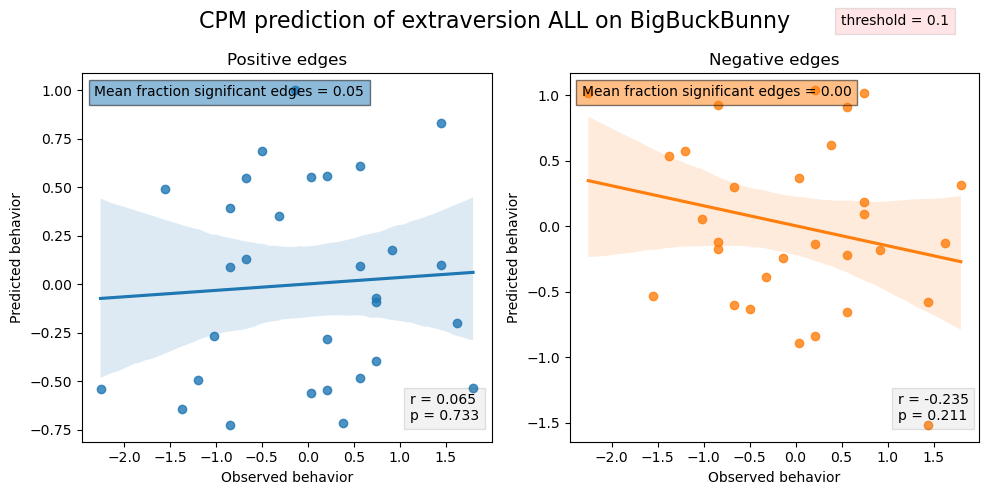

Number of significant points for BigBuckBunny and ALL and bold and 0.1 is: 0.0028929255291621375 and 0.053350928944780836
Positive edges: r = 0.065, p = 0.733
Negative edges: r = -0.235, p = 0.211
Computing CPM for BigBuckBunny and VIS and bold and 0.1
The shape of X for BOLD is:  (30, 136)


<Figure size 640x480 with 0 Axes>

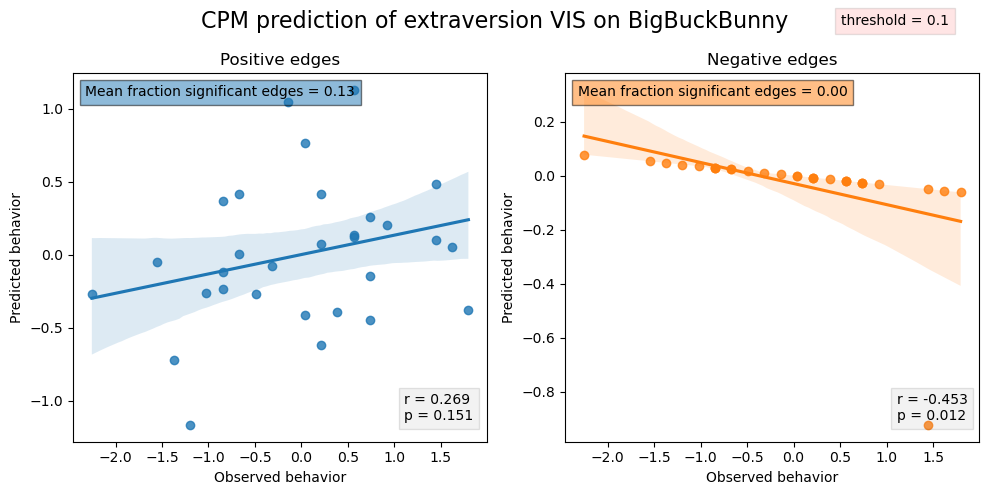

Number of significant points for BigBuckBunny and VIS and bold and 0.1 is: 0.00024509803921568627 and 0.1286764705882353
Positive edges: r = 0.269, p = 0.151
Negative edges: r = -0.453, p = 0.012
Computing CPM for BigBuckBunny and SM and bold and 0.1
The shape of X for BOLD is:  (30, 91)


<Figure size 640x480 with 0 Axes>

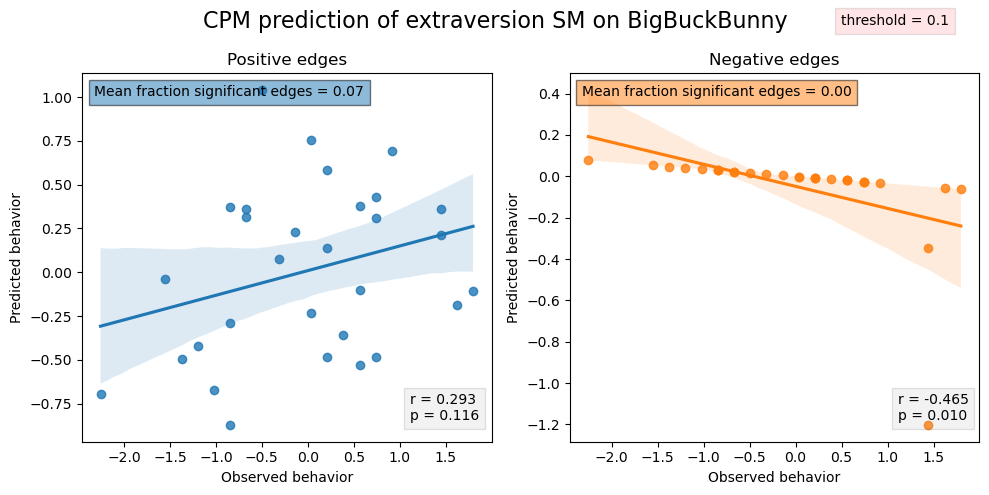

Number of significant points for BigBuckBunny and SM and bold and 0.1 is: 0.003296703296703297 and 0.06886446886446886
Positive edges: r = 0.293, p = 0.116
Negative edges: r = -0.465, p = 0.010
Computing CPM for BigBuckBunny and VA and bold and 0.1
The shape of X for BOLD is:  (30, 66)


<Figure size 640x480 with 0 Axes>

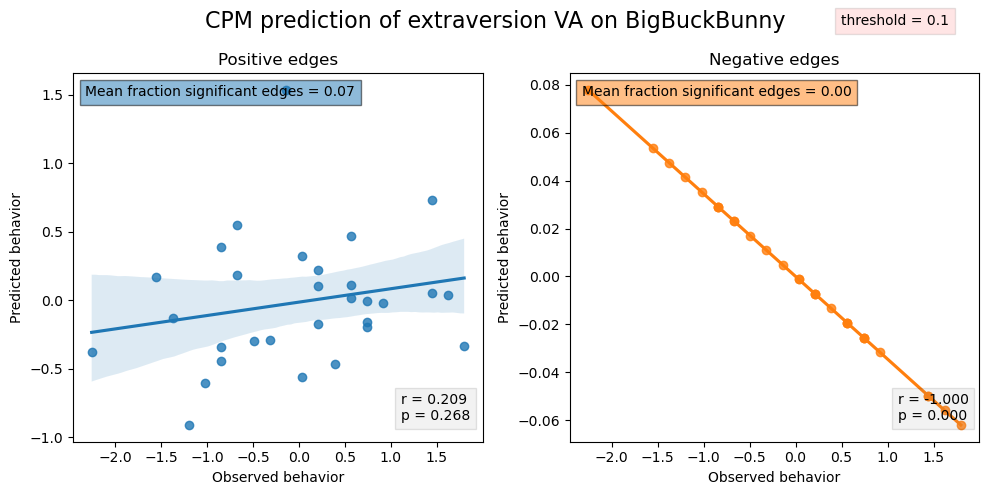

Number of significant points for BigBuckBunny and VA and bold and 0.1 is: 0.0 and 0.06969696969696969
Positive edges: r = 0.209, p = 0.268
Negative edges: r = -1.000, p = 0.000
Computing CPM for BigBuckBunny and DA and bold and 0.1
The shape of X for BOLD is:  (30, 105)


<Figure size 640x480 with 0 Axes>

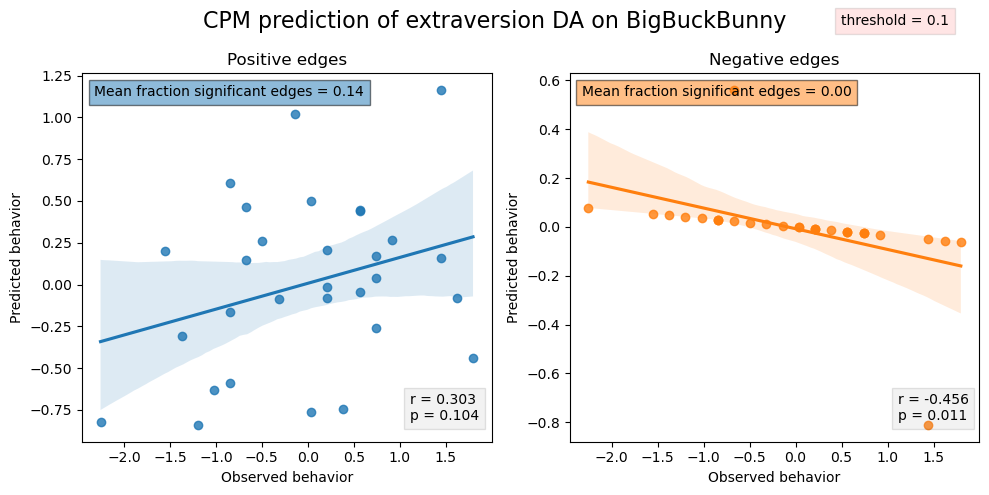

Number of significant points for BigBuckBunny and DA and bold and 0.1 is: 0.0009523809523809525 and 0.14444444444444443
Positive edges: r = 0.303, p = 0.104
Negative edges: r = -0.456, p = 0.011
Computing CPM for BigBuckBunny and DMN and bold and 0.1
The shape of X for BOLD is:  (30, 276)


<Figure size 640x480 with 0 Axes>

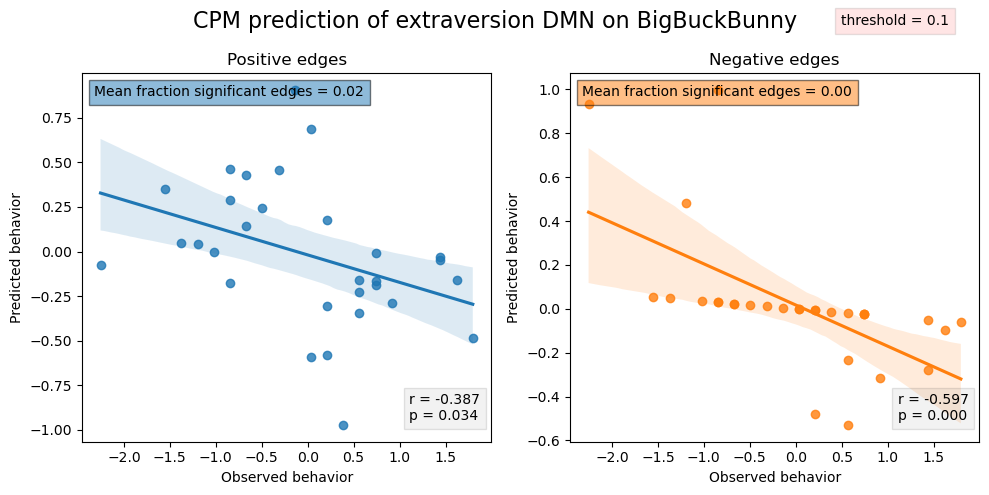

Number of significant points for BigBuckBunny and DMN and bold and 0.1 is: 0.0016908212560386474 and 0.017995169082125603
Positive edges: r = -0.387, p = 0.034
Negative edges: r = -0.597, p = 0.000
Computing CPM for BigBuckBunny and FP and bold and 0.1
The shape of X for BOLD is:  (30, 78)


<Figure size 640x480 with 0 Axes>

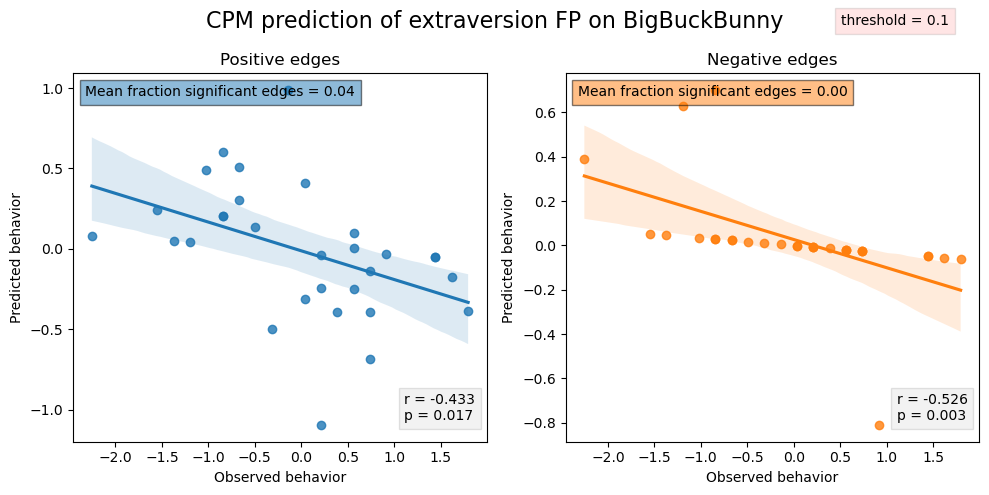

Number of significant points for BigBuckBunny and FP and bold and 0.1 is: 0.0017094017094017094 and 0.036752136752136746
Positive edges: r = -0.433, p = 0.017
Negative edges: r = -0.526, p = 0.003
Computing CPM for Chatter and ALL and bold and 0.1
The shape of X for BOLD is:  (30, 6441)


<Figure size 640x480 with 0 Axes>

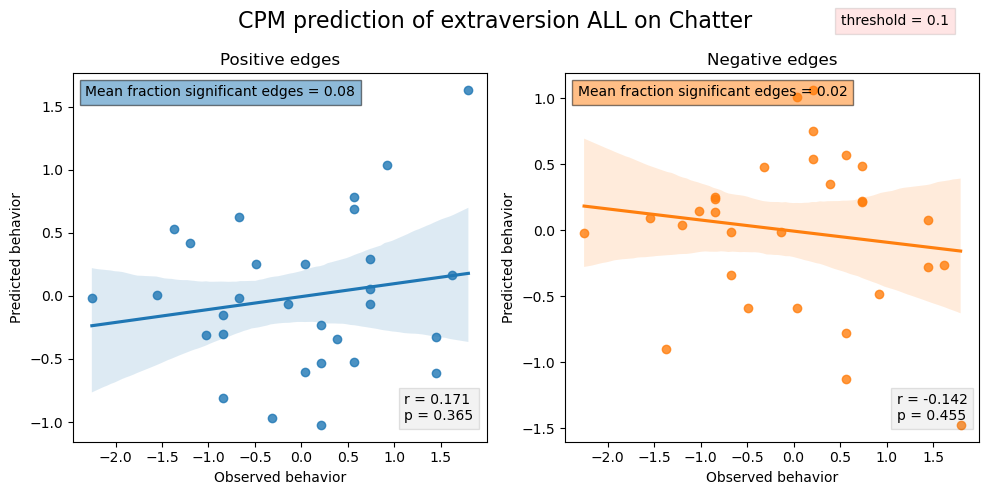

Number of significant points for Chatter and ALL and bold and 0.1 is: 0.01993996791388501 and 0.07981162345391501
Positive edges: r = 0.171, p = 0.365
Negative edges: r = -0.142, p = 0.455
Computing CPM for Chatter and VIS and bold and 0.1
The shape of X for BOLD is:  (30, 136)


<Figure size 640x480 with 0 Axes>

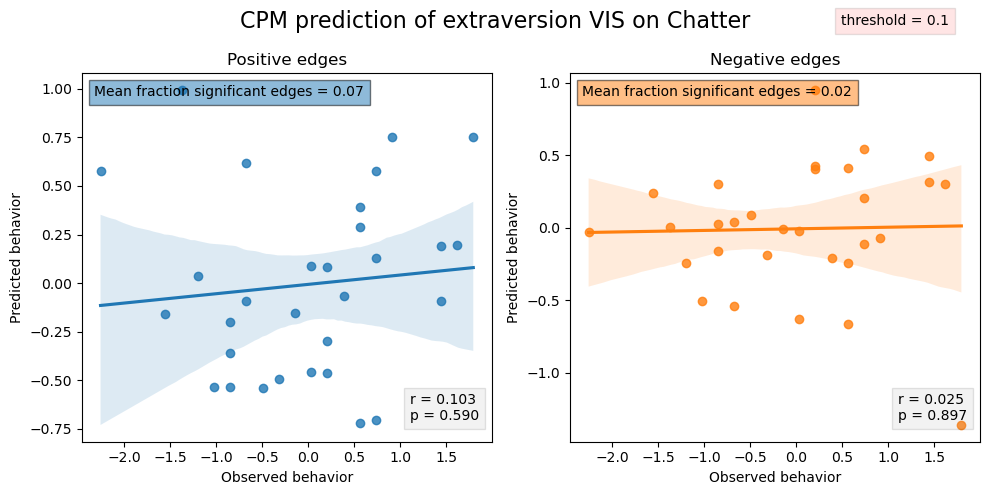

Number of significant points for Chatter and VIS and bold and 0.1 is: 0.019607843137254895 and 0.06691176470588235
Positive edges: r = 0.103, p = 0.590
Negative edges: r = 0.025, p = 0.897
Computing CPM for Chatter and SM and bold and 0.1
The shape of X for BOLD is:  (30, 91)


<Figure size 640x480 with 0 Axes>

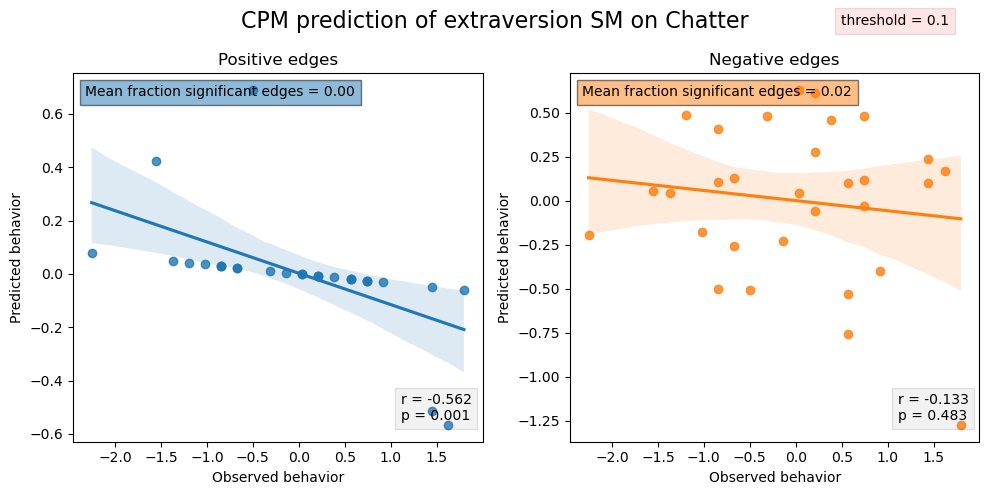

Number of significant points for Chatter and SM and bold and 0.1 is: 0.01501831501831502 and 0.0018315018315018315
Positive edges: r = -0.562, p = 0.001
Negative edges: r = -0.133, p = 0.483
Computing CPM for Chatter and VA and bold and 0.1
The shape of X for BOLD is:  (30, 66)


<Figure size 640x480 with 0 Axes>

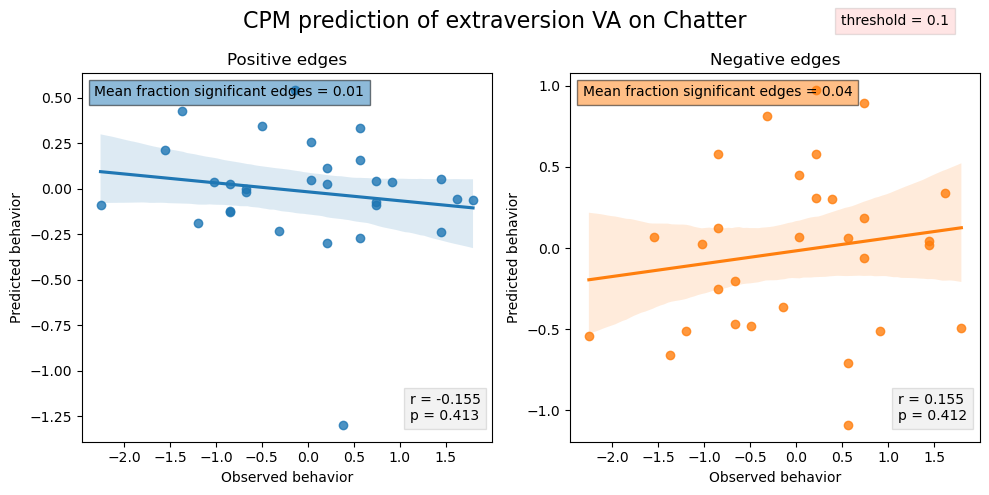

Number of significant points for Chatter and VA and bold and 0.1 is: 0.04292929292929292 and 0.013131313131313131
Positive edges: r = -0.155, p = 0.413
Negative edges: r = 0.155, p = 0.412
Computing CPM for Chatter and DA and bold and 0.1
The shape of X for BOLD is:  (30, 105)


<Figure size 640x480 with 0 Axes>

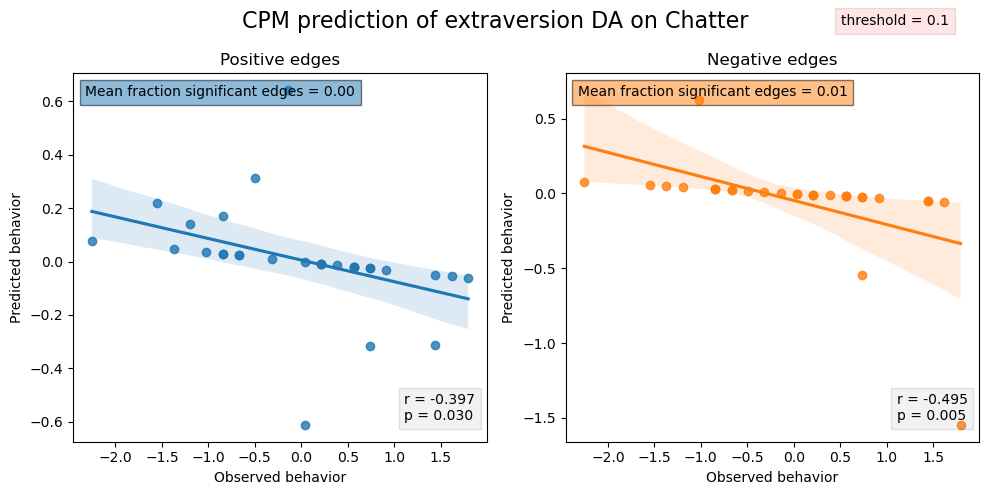

Number of significant points for Chatter and DA and bold and 0.1 is: 0.0050793650793650785 and 0.00253968253968254
Positive edges: r = -0.397, p = 0.030
Negative edges: r = -0.495, p = 0.005
Computing CPM for Chatter and DMN and bold and 0.1
The shape of X for BOLD is:  (30, 276)


<Figure size 640x480 with 0 Axes>

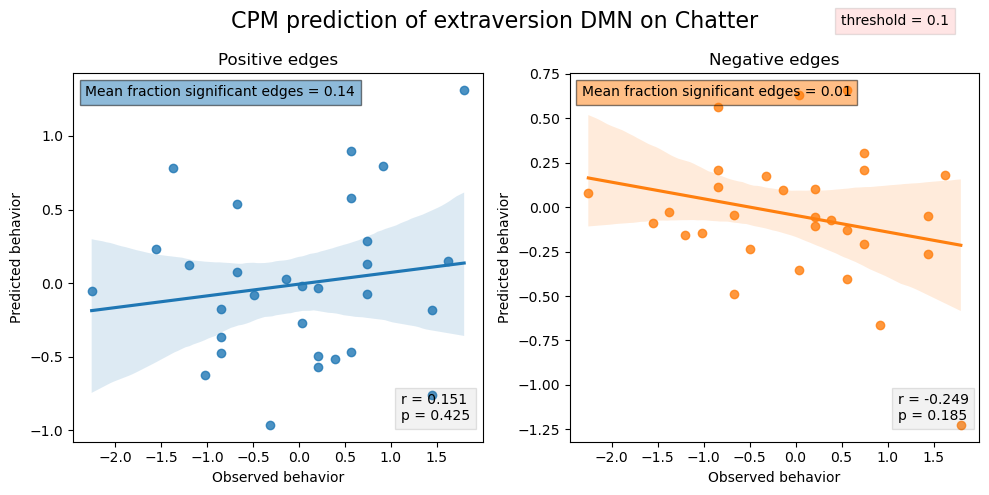

Number of significant points for Chatter and DMN and bold and 0.1 is: 0.005434782608695651 and 0.13876811594202898
Positive edges: r = 0.151, p = 0.425
Negative edges: r = -0.249, p = 0.185
Computing CPM for Chatter and FP and bold and 0.1
The shape of X for BOLD is:  (30, 78)


<Figure size 640x480 with 0 Axes>

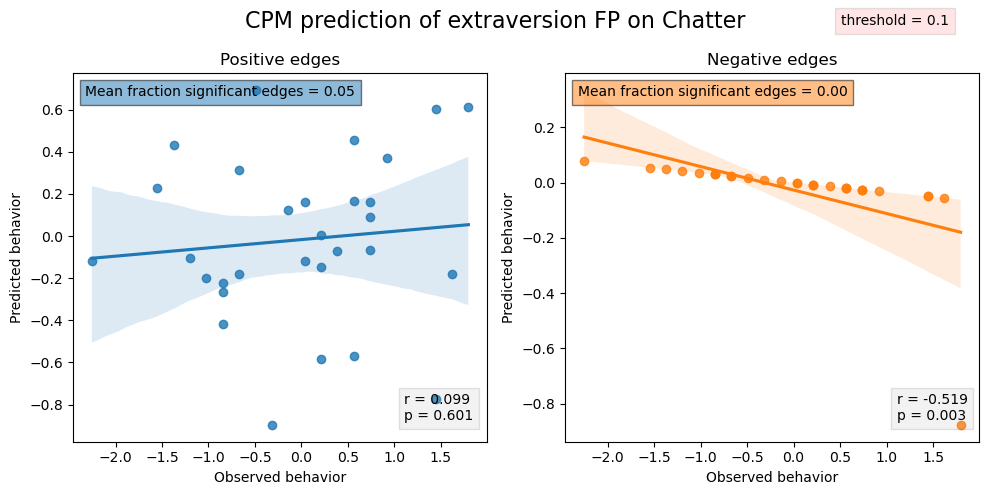

Number of significant points for Chatter and FP and bold and 0.1 is: 0.001282051282051282 and 0.052991452991453
Positive edges: r = 0.099, p = 0.601
Negative edges: r = -0.519, p = 0.003
Computing CPM for FirstBite and ALL and bold and 0.1
The shape of X for BOLD is:  (30, 6441)


In [113]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# CPM Function
def cpm(X_train, y_train, threshold):
    # 1. INPUTS: Divide the data into training and test sets
    M, N = X_train.shape[1], X_train.shape[0] 
    all_mats, all_behav = X_train, y_train
    all_mats = np.array(all_mats)
    all_behav = np.array(all_behav)

    # Preallocate prediction arrays
    behav_pred_pos = np.zeros((N, 1))
    behav_pred_neg = np.zeros((N, 1))
    
    # 2. CROSS VALIDATION: Perform leave-one-out procedure
    number_pos = []
    number_neg = []
    for leftout in range(N):
        # print(f'Leaving out subj # {leftout + 1:02.0f}')
        start = time.time()

        # Leave out subject from matrices and behavior
        train_mats = np.delete(all_mats, leftout, axis=0)
        train_behav = np.delete(all_behav, leftout, axis=0)

        # 3. RELATE EDGES: Correlate all edges with behavior
        r_mat = np.zeros((M))
        p_mat = np.zeros((M))

        for i in range(M):
            r, p = scipy.stats.pearsonr(train_mats[:, i], train_behav[:])
            r_mat[i] = r
            p_mat[i] = p

        # 4. EDGE SELECTION: Set threshold and define masks
        pos_mask = np.multiply(p_mat < threshold, r_mat > 0)
        neg_mask = np.multiply(p_mat < threshold, r_mat < 0)

        number_pos.append(np.sum(pos_mask) / M)
        number_neg.append(np.sum(neg_mask) / M)

        # 5. SINGLE SUBJ SUMMARY VALUES: Compute sum scores
        behav_sum_pos = np.zeros((N - 1, 1))
        behav_sum_neg = np.zeros((N - 1, 1))

        # Divide by two to control for the fact that we're counting each pair twice because the matrix is symmetric
        for i in range(N - 1):
            behav_sum_pos[i] = np.sum(np.multiply(train_mats[i, :], pos_mask))
            behav_sum_neg[i] = np.sum(np.multiply(train_mats[i, :], neg_mask))

        # 6. MODEL FITTING: Fit model on training set
        lin_model_pos = LinearRegression()
        lin_model_pos.fit(behav_sum_pos, train_behav)

        lin_model_neg = LinearRegression()
        lin_model_neg.fit(behav_sum_neg, train_behav)

        # 7. PREDICTION: Predict on left-out subject
        # Extract sum scores for left-out subject
        leftout_sum_pos = np.sum(np.multiply(all_mats[leftout], pos_mask))
        leftout_sum_neg = np.sum(np.multiply(all_mats[leftout], neg_mask))
        leftout_sum_pos = leftout_sum_pos.reshape(1,1)
        leftout_sum_neg = leftout_sum_neg.reshape(1,1)

        # Predict behavior for left-out subject
        behav_pred_pos[leftout] = lin_model_pos.predict(leftout_sum_pos)
        behav_pred_neg[leftout] = lin_model_neg.predict(leftout_sum_neg)

        end = time.time()
        minutes = (end - start) / 60
        seconds = (end - start) % 60

    mean_neg = np.mean(number_neg) 
    mean_pos = np.mean(number_pos)    

    return behav_pred_pos, behav_pred_neg, all_behav, mean_neg, mean_pos

def plot_cpm(behav_pred_pos, behav_pred_neg, all_behav, mean_neg, mean_pos, movie, region):

    # 8. EVALUATION: Compute correlations between predicted and observed behavior
    behav_pred_corr_pos = scipy.stats.pearsonr(all_behav, behav_pred_pos[:, 0])
    behav_pred_corr_neg = scipy.stats.pearsonr(all_behav, behav_pred_neg[:, 0])

    plt.figure(figsize=(10, 5))
    palette = sns.color_palette()
    plt.suptitle(f'CPM prediction of extraversion {region} on {movie}', fontsize=16)
    # add text at the bottom of the figure
    plt.figtext(0.90, 0.95, f'threshold = {threshold}', wrap=True, 
                horizontalalignment='center', fontsize=10, bbox=dict(facecolor='red', alpha=0.1))
    plt.subplot(1, 2, 1)
    sns.regplot(x = all_behav, y = behav_pred_pos, color = palette[0])
    plt.annotate(f'r = {behav_pred_corr_pos[0]:.3f}\np = {behav_pred_corr_pos[1]:.3f}', xy=[0.80, 0.05], xycoords='axes fraction', ha='left', va='bottom',
                bbox=dict(facecolor='grey', alpha=0.1))
    plt.annotate(f'Mean fraction significant edges = {mean_pos:.2f}', xy=[0.03, 0.93], xycoords='axes fraction', ha='left', va='bottom',
                bbox=dict(facecolor=palette[0], alpha=0.5))
    plt.xlabel('Observed behavior')
    plt.ylabel('Predicted behavior')
    plt.title('Positive edges')

    plt.subplot(1, 2, 2)
    sns.regplot(x = all_behav, y = behav_pred_neg, color=palette[1])
    plt.annotate(f'r = {behav_pred_corr_neg[0]:.3f}\np = {behav_pred_corr_neg[1]:.3f}', xy=[0.80, 0.05], xycoords='axes fraction', ha='left', va='bottom',
                bbox=dict(facecolor='grey', alpha=0.1))
    plt.annotate(f'Mean fraction significant edges = {mean_neg:.2f}', xy=[0.03, 0.93], xycoords='axes fraction', ha='left', va='bottom',
                bbox=dict(facecolor=palette[1], alpha=0.5))
    plt.xlabel('Observed behavior')
    plt.ylabel('Predicted behavior')
    plt.title('Negative edges')
    plt.tight_layout()

    plt.show()
    plt.savefig(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/CPM/{movie}_{region}_{threshold}_CPM.png')

# compute the CPM

# 1. I want to print the number of significant points for each threshold and each region
# 2. I want to plot the correlation between predicted and observed behaviour for each threshold and each region
number_points = {}
results = {}
for threshold in [0.1, 0.05, 0.01]:    
    method = 'bold'
    PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Data_TC/'
    for movie in list_movies:
        for region in ['ALL', 'VIS', 'SM', 'VA', 'DA', 'DMN', 'FP']:
            print(f'Computing CPM for {movie} and {region} and {method} and {threshold}')
            X = compute_X(PATH_DATA, movie, method, regions = region)
            behav_pred_pos, behav_pred_neg, all_behav, mean_neg, mean_pos = cpm(X, extrovercy, threshold)
            # put the data in a dataframe
            df = pd.DataFrame({'predicted_pos': behav_pred_pos[:, 0], 'predicted_neg': behav_pred_neg[:, 0], 'observed': all_behav})
            # save the dataframe
            df.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/{movie}_{region}_{threshold}_CPM.csv', index=False)

            plot_cpm(behav_pred_pos, behav_pred_neg, all_behav, mean_neg, mean_pos, movie, region)

            number_points[f'{movie}_{region}_{threshold}'] = [mean_neg, mean_pos]
            print(f'Number of significant points for {movie} and {region} and {method} and {threshold} is: {mean_neg} and {mean_pos}')

            r_pos, p_pos = scipy.stats.pearsonr(all_behav, behav_pred_pos[:, 0])
            r_neg, p_neg = scipy.stats.pearsonr(all_behav, behav_pred_neg[:, 0])
            print(f'Positive edges: r = {r_pos:.3f}, p = {p_pos:.3f}')
            print(f'Negative edges: r = {r_neg:.3f}, p = {p_neg:.3f}')

            results[f'{movie}_{region}_{threshold}'] = [r_pos, r_neg, p_pos, p_neg]
